# Convolutional neural networks for sentence classification

- CNN-rand : baseline값으로 사용하기 위해 사용. 모든 단어 벡터를 임의의 값으로 초기화해서 사용했다.
- CNN-static : 앞서 말한 사전 학습된 word2vec 단어 벡터를 사용한 모델이다.
- CNN-non-static : 위의 모델과 같이 학습된 벡터를 사용했지만 각 task에서 벡터값은 update된다.

논문에 소개된 위 3가지 모델을 구현하기 위함.

## - Contextualized Embedding

CNN - Random이 아닌 contextualized embedding을 사용하여 구현하였다.


In [2]:
import pandas as pd
import numpy as np
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import re

네이버리뷰 training file을 이용하기 위해 load

In [3]:
review = pd.read_csv("ratings_train.txt",sep='\t')
review

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


Null 값 제거

In [4]:
review.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [5]:
review[review['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [7]:
review = review.dropna()

### 전처리 과정

In [8]:
mecab = Mecab()

리뷰중 한글 이외의 글자 삭제 (전처리)

In [9]:
review['document'] = review['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

/home/haeun/anaconda3/envs/haeun/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


- mecab을 사용
- 불용어 제거 + tag N,V 만 남김

In [10]:
stopwords = ['의','가','이','은','지','구먼','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','그','것','게','인','아니','이게']


new = []
document_list = review['document'].tolist()
for document in document_list:
    temp = []
    temp = [token[0] for token in mecab.pos(document) if token[1][0] in ['N','V']]
    temp = [word for word in temp if not word in stopwords]
    new.append(temp)
    

In [11]:
review['new_tokens'] = new

/home/haeun/anaconda3/envs/haeun/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
review

,id,document,label,new_tokens
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[짜증, 나, 네요, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[포스터, 초딩, 영화, 줄, 오버, 연기, 가볍, 않]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,[]
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 재미, 없, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이몬페그, 익살, 연기, 돋보였, 영화, 스파이더맨, 늙, 보이, 했, 커스틴,..."
...,...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0,"[인간, 문제지, 소, 죄, 인가]"
149996,8549745,평점이 너무 낮아서,1,"[평점, 낮]"
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0,"[한국인, 거들먹거리, 필리핀, 혼혈, 착하]"
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1,"[청춘, 영화, 최고봉, 방황, 우울, 날, 자화상]"


위 전처리 과정을 똑같이 test / train 모두 진행함.

In [99]:
review.to_csv('review_.csv',encoding='utf-8-sig')
# review.to_pickle('review.pkl')

In [118]:
len(review['document']), len(docs)

(149995, 149995)

In [2]:
pip install tensorflow

     |████████████████████████████████| 320.4 MB 32 kB/s s eta 0:00:01  |▎                               | 3.2 MB 926 kB/s eta 0:05:43     |██▏                             | 21.6 MB 6.4 MB/s eta 0:00:47     |██▋                             | 25.8 MB 6.4 MB/s eta 0:00:46     |███                             | 29.4 MB 9.2 MB/s eta 0:00:32     |█████                           | 50.3 MB 7.9 MB/s eta 0:00:35     |█████                           | 51.1 MB 7.9 MB/s eta 0:00:35     |█████▉                          | 58.1 MB 1.7 MB/s eta 0:02:39     |██████▉                         | 68.0 MB 8.7 MB/s eta 0:00:29     |███████▎                        | 72.5 MB 8.7 MB/s eta 0:00:29     |█████████▋                      | 96.1 MB 7.5 MB/s eta 0:00:30     |███████████▊                    | 117.2 MB 6.7 MB/s eta 0:00:31     |████████████                    | 120.7 MB 9.5 MB/s eta 0:00:22     |████████████▏                   | 121.9 MB 9.5 MB/s eta 0:00:21     |████████████▍                   | 124.2 M

     |████████████████████████████████| 77 kB 2.1 MB/s  eta 0:00:01
  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=121931 sha256=41ec691cfaa58afdb506caf2733d082c482059236ba43ccca111e07e52c25176
  Stored in directory: /home/haeun/.cache/pip/wheels/c3/af/84/3962a6af7b4ab336e951b7877dcfb758cf94548bb1771e0679
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4830 sha256=558efc593569a81a8a2e0237a40d3ed95142315b9b543bd6b73ec345663289ff
  Stored in directory: /home/haeun/.cache/pip/wheels/93/2a/eb/e58dbcbc963549ee4f065ff80a59f274cc7210b6eab962acdc
Successfully built absl-py termcolor
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.0
    Uninstalling scipy-1.5.0:
      Successfully uninstalled scipy-1.5.0
Note: you may need to restart the kernel to use updated packages.


토큰 list 생성

In [13]:
token_list = [tokens for tokens in review['new_tokens'].tolist()]
token_list

[['짜증', '나', '네요', '목소리'],
 ['포스터', '초딩', '영화', '줄', '오버', '연기', '가볍', '않'],
 [],
 ['교도소', '이야기', '재미', '없', '평점', '조정'],
 ['사이몬페그',
  '익살',
  '연기',
  '돋보였',
  '영화',
  '스파이더맨',
  '늙',
  '보이',
  '했',
  '커스틴',
  '던스트',
  '이뻐',
  '보였'],
 ['걸음마', '뗀', '세', '초등', '학교', '학년', '살용', '영화', '개', '아까움'],
 ['원작', '긴장감', '살려', '내', '못했'],
 ['반개',
  '아깝',
  '욕',
  '나온다',
  '이응경',
  '길용우',
  '연기',
  '생활',
  '년',
  '인지',
  '발',
  '해도',
  '그것',
  '낫',
  '납치',
  '감금',
  '반복',
  '반복',
  '드라마',
  '가족',
  '없',
  '연기',
  '하',
  '사람',
  '모엿'],
 ['액션', '없', '재미', '있', '되', '영화'],
 ['평점', '낮', '건데', '볼', '만', '헐리우드', '길들여져', '있'],
 [],
 ['볼', '때', '눈물나', '죽', '년', '대', '향수', '자극', '허진호', '감성', '절제', '멜로', '달인'],
 ['울', '손들', '횡단', '보도', '건널', '때', '뛰쳐나올', '뻔', '이범수', '연기', '드럽', '못해'],
 ['좋', '신문', '기사', '보', '잊어버린다', '사람'],
 ['취향',
  '존중',
  '내생',
  '극장',
  '본',
  '영화',
  '중',
  '잼',
  '감동',
  '임',
  '스토리',
  '거지',
  '감동',
  '어거지'],
 ['ㄱ', '냥', '긴장', '밋'],
 ['사람',
  '웃긴',
  '바스코',
  '이기면',
  '락스',
  '코',
  '

In [34]:
type(list(review['new_tokens']))

list

In [40]:
train=pd.read_pickle('train.pkl')
test=pd.read_pickle('test.pkl')

In [41]:
train

,id,document,label,tokens
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[짜증, 나, 네요, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[포스터, 초딩, 영화, 줄, 오버, 연기, 가볍, 않]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,[]
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기, 재미, 없, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이몬페그, 익살, 연기, 돋보였, 영화, 스파이더맨, 늙, 보이, 했, 커스틴,..."
...,...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0,"[인간, 문제지, 소, 죄, 인가]"
149996,8549745,평점이 너무 낮아서,1,"[평점, 낮]"
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0,"[한국인, 거들먹거리, 필리핀, 혼혈, 착하]"
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1,"[청춘, 영화, 최고봉, 방황, 우울, 날, 자화상]"


In [42]:
test

,id,document,label,tokens
0,6270596,굳 ㅋ,1,[굳]
1,9274899,,0,[]
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0,"[뭐, 야, 평점, 나쁘, 않, 점]"
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,"[않, 완전, 막장, 임, 돈, 주, 보]"
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0,"[다섯, 개, 줬, 텐데, 로, 나와서, 제, 심기, 불편, 하]"
...,...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,"[오랜만, 평점, 했, 킹왕짱, 쌈, 뽕, 영화, 만났, 육, 쾌]"
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0,"[의지, 박약, 하, 거, 탈영, 주인공, 김대희, 닮, 이등병, 찐따]"
49997,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0,"[그림, 좋, 완성도, 높, 보, 불안, 만든다]"
49998,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0,"[봐서, 될, 영화, 재미, 없, 기분, 잡치, 세트, 장, 해, 먹]"


### CNN modeling

- Contextualized embedding

In [14]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

실행할때마다 결과가 바뀌어서 set_seed 설정해주었음

In [16]:
tf.random.set_seed(1234) 

In [17]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
truct_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 120000

In [18]:
sentences = []
labels = []

for i in token_list:
    sentences.append(i)
for i in review['label']:
    labels.append(i)

In [19]:
type(sentences),type(token_list),len(sentences),len(labels)

(list, list, 149995, 149995)

In [43]:
training_sentences = list(train['tokens'])
testing_sentences = list(test['tokens'])

training_labels = list(train['label'])
testing_labels = list(test['label'])

In [44]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,maxlen=max_length,padding = padding_type,truncating = truct_type)


testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length,padding = padding_type,truncating = truct_type)

In [45]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [46]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

Irelu activation 사용

In [47]:
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(32,activation ='relu'),
                             tf.keras.layers.Dense(16,activation='relu')])
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(16,activation=lrelu))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)               

In [49]:
num_epochs = 50
history = model.fit(training_padded,training_labels,epochs=num_epochs,validation_data = (testing_padded,testing_labels),verbose =2)

Epoch 1/50
4688/4688 - 14s - loss: 0.2914 - accuracy: 0.8728 - val_loss: 0.5450 - val_accuracy: 0.7545
Epoch 2/50
4688/4688 - 14s - loss: 0.2909 - accuracy: 0.8747 - val_loss: 0.5604 - val_accuracy: 0.7779
Epoch 3/50
4688/4688 - 28s - loss: 0.2893 - accuracy: 0.8742 - val_loss: 0.5053 - val_accuracy: 0.7957
Epoch 4/50
4688/4688 - 17s - loss: 0.2872 - accuracy: 0.8759 - val_loss: 0.4940 - val_accuracy: 0.7891
Epoch 5/50
4688/4688 - 14s - loss: 0.2856 - accuracy: 0.8770 - val_loss: 0.4943 - val_accuracy: 0.7930
Epoch 6/50
4688/4688 - 14s - loss: 0.2836 - accuracy: 0.8776 - val_loss: 0.5178 - val_accuracy: 0.7933
Epoch 7/50
4688/4688 - 15s - loss: 0.2813 - accuracy: 0.8781 - val_loss: 0.5143 - val_accuracy: 0.7880
Epoch 8/50
4688/4688 - 15s - loss: 0.2818 - accuracy: 0.8774 - val_loss: 0.5225 - val_accuracy: 0.7848
Epoch 9/50
4688/4688 - 16s - loss: 0.2789 - accuracy: 0.8786 - val_loss: 0.4995 - val_accuracy: 0.7968
Epoch 10/50
4688/4688 - 15s - loss: 0.2787 - accuracy: 0.8795 - val_loss:

#### *** Result ***
#### accuracy : 0.8634   val_accuaracy : 0.8040

Graph

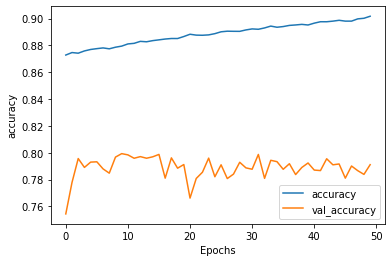

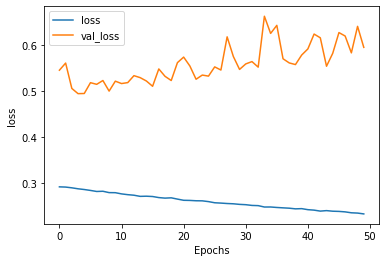

In [50]:
import matplotlib.pyplot as plt

def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])    
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()
    
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

# training set 에 과적합 된 것 (전처리 때문 ?)

### Model Save

In [27]:
# model save to json
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)


In [28]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [29]:
# model weight save
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
